In [1]:
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import os
import numpy as np
from torch import optim
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from torchsummary import summary
import sys
sys.path.append('utils')
from data_utils import *
import model_utils
from model_utils import *
from training_utils import *

samplerate = 16000
frame_length_ms = 12
frame_length_samples = int(samplerate * frame_length_ms / 1000)
hop_length_samples = 1
channels = 128
VRP_path = '/workspace/audio'
VRP_path = r'F:\audio\test_VRP'

# lr = [1e-3, 1e-4, 1e-5]
# weight_decay = [1e-2, 1e-3, 1e-4]
# channels = [128, 256, 512]
# gamma = [0.1, 0.5, 0.9]
# dropout = [0.1, 0.3, 0.5]
# dilation_layers = [6, 8, 10]
# kernel_size = [3, 5, 7]
# stride = [1, 10, 100]
# frame_length_ms = [12, 48, 192]

if torch.cuda.is_available():
    print("CUDA is available. List of all available GPUs:")
    print(torch.cuda.device_count(), "GPUs available")
    for i in range(torch.cuda.device_count()):
        print("GPU", i, ":", torch.cuda.get_device_name(i))
else:
    print("CUDA is not available, using CPU instead.")

import sys
print("Python executable path:", sys.executable)

CUDA is available. List of all available GPUs:
1 GPUs available
GPU 0 : NVIDIA GeForce RTX 3070
Python executable path: g:\Conda\envs\EGG\python.exe


In [2]:
experiment_name = input("Enter the experiment name or identifier: ")

# load data in a folder
audio, egg = load_data(VRP_path, samplerate)
audio = voice_preprocess(audio, samplerate)
egg = process_EGG_signal(egg, samplerate)
audio = audio / np.max(np.abs(audio))
egg = egg / np.max(np.abs(egg))

# segment audio
audio_frames = segment_audio(audio, samplerate, frame_length_ms, hop_length_samples)
egg_frames = segment_audio(egg, samplerate, frame_length_ms, hop_length_samples)


# audio_frames, egg_frames = load_and_preprocess_data(VRP_path, VRP_path, samplerate, frame_length_ms, hop_length_samples)

print(audio_frames.shape)

Processing frames: 100%|██████████| 1120/1120 [00:00<00:00, 4525.74it/s]


(1119569, 192)


In [3]:
import importlib
importlib.reload(model_utils)
from model_utils import *

# Instantiate dataset
dataset = AudioEGGDataset(audio_frames, egg_frames)
# Create train and validation and test sets
batch_size = 128  # Adjust as necessary
train_size = int(0.85 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
torch.manual_seed(0)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Training
base_dir = r'F:\A2E git\A2E'
chkpt_dir, models_dir, logs_dir = create_experiment_folders(base_dir, experiment_name)
# After training, load the best model for direct usage
best_model_path = os.path.join(models_dir, 'best_model.pt')

# Instantiate the model

model = WaveNet_a2e(input_channels=1, dilation_channels=channels, dilation_layers=6, dropout=0.3)
total_params = sum(p.numel() for p in model.parameters())

print(f"Total parameters in the model: {total_params}")


if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
    for i in range(torch.cuda.device_count()):
        print(f"Using GPU {i}: {torch.cuda.get_device_name(i)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

# summary(model, input_size=(1, frame_length_samples), device=device.type)

# Instantiate the TensorBoard writer
writer = SummaryWriter(log_dir=logs_dir)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

# Instantiate the Cosine Similarity Loss
# criterion = CosineSimilarityLoss()
criterion = nn.MSELoss()
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
best_val_loss = float('inf')

Total parameters in the model: 719937


In [4]:
model, optimizer, scheduler, starting_epoch, best_val_loss = load_checkpoint(model, optimizer, scheduler, chkpt_dir)
early_stopper = EarlyStopping(patience=10, verbose=True, delta=0)
train_model(model, dataloader, val_dataloader, starting_epoch, device, criterion, optimizer, scheduler, writer, early_stopper, chkpt_dir, num_epochs=500)

No checkpoint found. Starting a new model.


Validation Loss: 0.04560606654201235
Validation loss decreased (inf --> 0.045606). Saving model...
Early stop: Checkpoint saved at F:\A2E git\A2E\Trial20\chkpt\checkpoint_1.pt


Validation Loss: 0.037417483227593556
Validation loss decreased (0.045606 --> 0.037417). Saving model...


Validation Loss: 0.03510111831128597
Validation loss decreased (0.037417 --> 0.035101). Saving model...


Validation Loss: 0.03661241475599153
EarlyStopping counter: 1 out of 10


Validation Loss: 0.03734264767808573
EarlyStopping counter: 2 out of 10


Validation Loss: 0.036031645723751615
EarlyStopping counter: 3 out of 10


Validation Loss: 0.03594035706562655
EarlyStopping counter: 4 out of 10


Validation Loss: 0.03860690792330674
EarlyStopping counter: 5 out of 10


Validation Loss: 0.03552541687658855
EarlyStopping counter: 6 out of 10


Validation Loss: 0.03762183089341436
EarlyStopping counter: 7 out of 10


Validation Loss: 0.0368520719983748
EarlyStopping counter: 8 out of 10
Early stop: Checkpoint saved at F:\A2E git\A2E\Trial20\chkpt\checkpoint_11.pt


Validation Loss: 0.03615770581577506
EarlyStopping counter: 9 out of 10


Validation Loss: 0.036038112874541964
EarlyStopping counter: 10 out of 10
Early stopping


In [5]:
model.eval()
with torch.no_grad():
    predictions = []
    targets = []
    for data in test_dataloader:
        a, e = data
        a = a.to(device)
        e = e.to(device)
        output = model(a)
        predictions.append(output.cpu())
        targets.append(e.cpu())

predictions = torch.cat(predictions, dim=0)
targets = torch.cat(targets, dim=0)

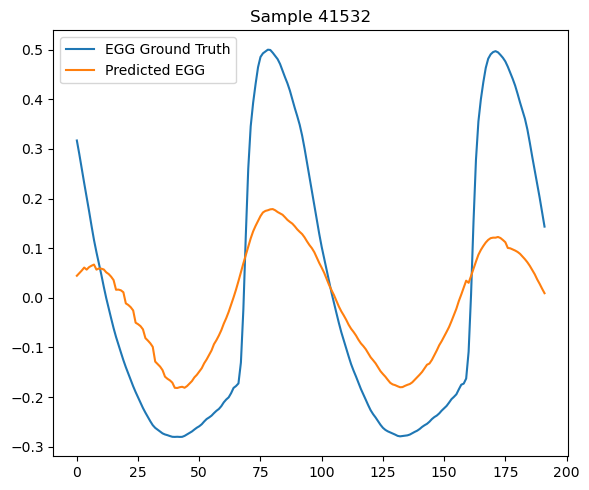

In [30]:
num_samples = 1
samples = np.random.randint(0, len(targets), size=num_samples)

plt.figure(figsize=(6, 5 * num_samples))
for i, sample in enumerate(samples, 1):
    plt.subplot(num_samples, 1, i)
    egg_sample = targets[sample].squeeze()
    output_sample = predictions[sample].squeeze()
    plt.plot(egg_sample, label='EGG Ground Truth')
    plt.plot(output_sample, label='Predicted EGG')
    plt.legend()
    plt.title(f'Sample {sample}')

plt.tight_layout()
plt.show()

In [7]:
# VAE WaveNet Attention

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class WaveNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(WaveNetLayer, self).__init__()
        self.dilated_conv = nn.Conv1d(in_channels, out_channels, kernel_size, dilation=dilation, padding=(kernel_size-1)*dilation)
        self.residual_conv = nn.Conv1d(out_channels, in_channels, 1)
        self.skip_conv = nn.Conv1d(out_channels, in_channels, 1)

    def forward(self, x):
        out = self.dilated_conv(x)
        tanh_out = torch.tanh(out)
        sigm_out = torch.sigmoid(out)
        out = tanh_out * sigm_out
        residual = self.residual_conv(out)
        skip = self.skip_conv(out)
        return residual + x, skip

class WaveNet(nn.Module):
    def __init__(self, in_channels, res_channels, layers, kernel_size=2):
        super(WaveNet, self).__init__()
        self.layers = nn.ModuleList([WaveNetLayer(in_channels, res_channels, kernel_size, 2**i) for i in range(layers)])

    def forward(self, x):
        skip_connections = []
        for layer in self.layers:
            x, skip = layer(x)
            skip_connections.append(skip)
        return torch.sum(torch.stack(skip_connections), dim=0)

class Attention(nn.Module):
    def __init__(self, query_dim, key_dim, value_dim):
        super(Attention, self).__init__()
        self.query_layer = nn.Linear(query_dim, value_dim)
        self.key_layer = nn.Linear(key_dim, value_dim)
        self.value_layer = nn.Linear(key_dim, value_dim)

    def forward(self, query, key, value):
        queries = self.query_layer(query)
        keys = self.key_layer(key)
        values = self.value_layer(value)
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / (keys.size(-1) ** 0.5)
        attn_weights = F.softmax(scores, dim=-1)
        context = torch.matmul(attn_weights, values)
        return context, attn_weights

class VAEWaveNetAttention(nn.Module):
    def __init__(self, input_dim, latent_dim, wavenet_channels, wavenet_layers, attention_dim):
        super(VAEWaveNetAttention, self).__init__()
        self.vae = VAE(input_dim, latent_dim)
        self.wavenet = WaveNet(latent_dim, wavenet_channels, wavenet_layers)
        self.attention = Attention(latent_dim, latent_dim, attention_dim)

    def forward(self, x):
        recon_x, mu, logvar = self.vae(x)
        recon_x = recon_x.view(recon_x.size(0), -1, 1)  # 重塑张量形状
        wavenet_out = self.wavenet(recon_x).view(recon_x.size(0), -1)  # 重塑张量形状
        context, _ = self.attention(wavenet_out, wavenet_out, wavenet_out)
        return context, mu, logvar

# 超参数
input_dim = 784
latent_dim = 32
wavenet_channels = 64
wavenet_layers = 10
attention_dim = 32
batch_size = 16

# 生成随机数据
data = torch.randn(batch_size, input_dim)

# 初始化模型
model = VAEWaveNetAttention(input_dim, latent_dim, wavenet_channels, wavenet_layers, attention_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 损失函数
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 前向传播
model.train()
optimizer.zero_grad()
context, mu, logvar = model(data)
loss = loss_function(context, data, mu, logvar)
loss.backward()
optimizer.step()

print(f"Loss: {loss.item()}")


RuntimeError: Given groups=1, weight of size [64, 32, 2], expected input[16, 784, 1] to have 32 channels, but got 784 channels instead

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, residual_channels, dilation_channels, skip_channels, kernel_size, dilation):
        super(ResidualBlock, self).__init__()
        self.dilated_conv = nn.Conv1d(residual_channels, 2 * dilation_channels, kernel_size, 
                                      padding=(kernel_size-1) * dilation, dilation=dilation)
        self.residual_conv = nn.Conv1d(dilation_channels, residual_channels, kernel_size=1)
        self.skip_conv = nn.Conv1d(dilation_channels, skip_channels, kernel_size=1)

    def forward(self, x):
        out = self.dilated_conv(x)
        out = torch.tanh(out[:, :out.size(1)//2, :]) * torch.sigmoid(out[:, out.size(1)//2:, :])
        residual = self.residual_conv(out[:, :x.size(1), :x.size(2)])  # Adjusted to match sizes
        skip = self.skip_conv(out[:, :x.size(1), :x.size(2)])  # Adjusted to match sizes
        return x + residual, skip

class WaveNet(nn.Module):
    def __init__(self, residual_channels, dilation_channels, skip_channels, num_blocks, num_layers):
        super(WaveNet, self).__init__()
        self.receptive_field = 1
        self.residual_blocks = nn.ModuleList()

        for b in range(num_blocks):
            for i in range(num_layers):
                dilation = 2 ** i
                self.residual_blocks.append(ResidualBlock(residual_channels, dilation_channels, skip_channels, kernel_size=2, dilation=dilation))
                self.receptive_field += (2 - 1) * dilation

        self.conv_out = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(skip_channels, skip_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(skip_channels, 1, kernel_size=1)
        )

        # Linear layers to adjust input and output dimensions
        self.input_linear = nn.Linear(192, 32 * 100)  # Adjust input size to match WaveNet's expectation
        self.output_linear = nn.Linear(100, 192)  # Adjust output size to match the required shape

    def forward(self, x):
        x = self.input_linear(x).view(1, 32, -1)  # Adjust input size and reshape

        skip_connections = []
        for block in self.residual_blocks:
            x, skip = block(x)
            skip_connections.append(skip)

        out = sum(skip_connections)
        out = self.conv_out(out)
        out = out.view(1, -1)  # Flatten the output
        out = self.output_linear(out)  # Adjust output size
        return out

# Example usage:
model = WaveNet(residual_channels=32, dilation_channels=32, skip_channels=256, num_blocks=2, num_layers=10)
input = torch.randn(1, 192)  # Input shape [1, 192]
output = model(input)  # Output shape [1, 192]
print(output.shape)  # Should print: torch.Size([1, 192])
